# Import data and get things setup

In [52]:
import random
random.seed(9001)

In [53]:
# turn on the magic so we have inline figures
%pylab inline
import matplotlib
matplotlib.style.use('ggplot')
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['sin', 'pi', 'median', 'random', 'percentile', 'save', 'deprecated', 'Rectangle', 'load', 'mean', 'plot', 'cos']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [54]:
# import code to write r modules and create our variable we'll write to
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

r = {}
def remember(name, x):
    r[name] = x
    display(x)

In [55]:
# load in modules we'll need for analysis
import subprocess
import csv
from igraph import *
import pandas as pd
import numpy as np
import re

In [56]:
# grab the largest connected compontent with a little function
def get_largest_component(g):
    g_components = g.components(mode="WEAK")
    max_size = max(g_components.sizes())
    for g_tmp in g_components.subgraphs():
        if g_tmp.vcount() == max_size:
            return(g_tmp)

In [57]:
# look the full edgelist into igraph
def edge_list_iter(df):
    for i, row in df.iterrows():
        yield (row['from'], row['to'])

In [58]:
# list top 5 journals for each of the clusters
def top_journals_for_clusters(clu):
    articles_tmp = pd.merge(clu, articles[['eid', 'source_title']])
    
    output = pd.DataFrame()
    for cid in articles_tmp['cluster'].unique():
        journal_counts = articles_tmp['source_title'][articles_tmp['cluster'] == cid].value_counts().head(5)
        tmp = pd.DataFrame({'cluster' : cid, 'count' : journal_counts })        
        output = output.append(tmp)

    output = output.reset_index()
    output = output.rename(columns = {'index' : "journal"})
    return(output)

In [59]:
def infomap_edgelist(g, edgelist_filename, directed=True):
    nodes_tmp = pd.DataFrame([ {'node_infomap' : v.index, 
                                'eid' : v['name']} for v in g.vs ])

    # write out the edgelist to an external file so we can call infomap on it
    with open(edgelist_filename + ".txt", 'w') as f:
        for e in g.es:
            if e.source != e.target:
                if 'weight' in e.attributes():
                    print("{}\t{}\t{}".format(e.source, e.target, e['weight']), file=f)
                else:
                    print("{}\t{}".format(e.source, e.target), file=f)

                    
    # run the external program to generate the infomap clustering
    infomap_cmdline = ["infomap/Infomap", edgelist_filename + ".txt", "output_dir -z --map --clu --tree"]
    if directed:
        infomap_cmdline.append("-d")
    subprocess.call(infomap_cmdline)

    # load up the clu data
    clu = pd.read_csv("output_dir/" + edgelist_filename + ".clu",
                      header=None, comment="#", delim_whitespace=True)
    clu.columns = ['node_infomap', 'cluster', 'flow']
    
    return pd.merge(clu, nodes_tmp, on="node_infomap")

In [60]:
def write_graphml(g, clu, graphml_filename):
    clu = clu[['node_infomap', 'cluster']].sort_values('node_infomap')
    g.vs["cluster"] =  clu["cluster"].tolist()
    g.write_graphml(graphml_filename)

In [61]:
# load article data
articles = pd.read_csv("../../processed_data/abstracts.tsv", delimiter="\t")

# network for just the central "social media" set

In [62]:
# this contains the list of all INCOMING citations to for paper in the original set
raw_edgelist = pd.read_csv("../../processed_data/social_media_edgelist.txt", delimiter="\t")

In [63]:
g_sm_all = Graph.TupleList([i for i in edge_list_iter(raw_edgelist)], directed=True)

In [64]:
g_sm = get_largest_component(g_sm_all)
g_sm = g_sm.simplify()

In [65]:
g_sm_clu = infomap_edgelist(g_sm, "sm_edgelist_infomap", directed=True)

In [66]:
g_sm_clu['cluster'].value_counts()

2     1817
1     1748
3     1088
4      653
6      355
10     114
5      104
9       90
8       59
7       44
12      27
11      19
13      10
14       5
15       3
16       2
18       1
17       1
Name: cluster, dtype: int64

In [67]:
tmp = top_journals_for_clusters(g_sm_clu)
tmp[tmp.cluster == 9]

journal  cluster  count
40  Lecture Notes in Computer Science (including s...        9      4
41  WSDM 2013 - Proceedings of the 6th ACM Interna...        9      4
42  Conference on Human Factors in Computing Syste...        9      2
43  WWW 2013 Companion - Proceedings of the 22nd I...        9      2
44                                           PLoS ONE        9      2

In [68]:
write_graphml(g_sm, g_sm_clu, "g_sm.graphml")

# larger network that contains the incoming cites to citing articles

In [69]:
# this contains the list of all INCOMING citations to everything in the original set
# plus every INCOMING citation to every paper that cites one of those papers
raw_edgelist_files = ["../../processed_data/citation_edgelist.txt",
                      "../../processed_data/social_media_edgelist.txt"]
combo_raw_edgelist = pd.concat([pd.read_csv(x, delimiter="\t") for x in raw_edgelist_files])

In [70]:
g_full_all = Graph.TupleList([i for i in edge_list_iter(combo_raw_edgelist)], directed=True)

In [71]:
g_full = get_largest_component(g_full_all)
g_full = g_full.simplify()

In [72]:
g_full_clu = infomap_edgelist(g_full, "citation_edglist_infomap", directed=True)

In [73]:
g_full_clu['cluster'].value_counts()

1     9243
2     8225
3     6826
4     3227
6     2835
5     2704
7     1911
9      810
8      803
10     589
11     520
12     491
13     336
14     219
15     175
17     162
16     153
22     139
18     135
19     118
25     117
23     106
21      93
24      88
30      84
28      79
27      78
32      76
26      73
20      71
      ... 
54      26
56      25
52      23
49      23
55      22
58      19
62      18
61      18
63      18
60      17
66      15
59      15
57      15
65      14
68      13
53       7
64       6
73       6
71       4
70       4
74       3
67       3
72       3
69       3
75       2
78       1
79       1
77       1
80       1
76       1
Name: cluster, Length: 80, dtype: int64

In [74]:
top_journals_for_clusters(g_full_clu)

journal  cluster  count
0                              Public Relations Review        1    119
1    Lecture Notes in Computer Science (including s...        1     81
2                          Computers in Human Behavior        1     71
3    Proceedings of the Annual Hawaii International...        1     49
4                     Government Information Quarterly        1     40
5                 Journal of Medical Internet Research        2    149
6                                             PLoS ONE        2     43
7         Studies in Health Technology and Informatics        2     41
8    Lecture Notes in Computer Science (including s...        2     32
9                         Annals of Emergency Medicine        2     17
10   Lecture Notes in Computer Science (including s...        3    180
11      ACM International Conference Proceeding Series        3     51
12   International Conference on Information and Kn...        3     38
13                           CEUR Workshop Proceedings        3     37
14                                            PLoS ONE        3     36
15               Information Communication and Society        4     70
16                               New Media and Society        4     34
17                                        First Monday        4     24
18   Lecture Notes in Computer Science (including s...        4     23
19                         Computers in Human Behavior        4     21
20                         Computers in Human Behavior        5     42
21    Cyberpsychology, Behavior, and Social Networking        5     42
22              Personality and Individual Differences        5     11
23                Journal of Medical Internet Research        5     11
24                        Journal of Adolescent Health        5     11
25                         Computers in Human Behavior        6     38
26   Lecture Notes in Computer Science (including s...        6     24
27                             Computers and Education        6     16
28   Conference on Human Factors in Computing Syste...        6     11
29                      Journal of Marketing Education        6     11
..                                                 ...      ...    ...
286                       Medical Journal of Australia       63      1
287                      Nicotine and Tobacco Research       63      1
288  35th International Conference on Information S...       64      1
289                                       First Monday       64      1
290   Cyberpsychology, Behavior, and Social Networking       64      1
291  HT'12 - Proceedings of 23rd ACM Conference on ...       65      1
292                IEEE/ACM Transactions on Networking       65      1
293                  Journal of Healthcare Engineering       65      1
294    International Journal of Information Management       66      2
295  Journal of Theoretical and Applied Electronic ...       66      1
296  Journal of Experimental and Theoretical Artifi...       66      1
297                                 McKinsey Quarterly       66      1
298  Lecture Notes in Computer Science (including s...       66      1
299                           Science (New York, N.Y.)       67      1
300  International Conference on Information and Kn...       68      1
301  Lecture Notes in Computer Science (including s...       68      1
302  16th Americas Conference on Information System...       68      1
303                               Procedia Engineering       68      1
304  International Journal of Virtual and Personal ...       68      1
305                                     Scientometrics       69      1
306  Conference on Human Factors in Computing Syste...       70      2
307                                                NyS       71      2
308    Aslib Proceedings: New Information Perspectives       71      1
309  WWW 2013 Companion - Proceedings of the 22nd I...       72      1
310   Cyberpsychology, Behavior, and Social Networking       72      1


In [75]:
write_graphml(g_full, g_full_clu, "g_full.graphml")

# create the meta-network of connections between clusters

In [76]:
edgelist_tmp = pd.merge(raw_edgelist, g_sm_clu[["eid", "cluster"]], how="inner", left_on="to", right_on="eid")
edgelist_tmp = edgelist_tmp.rename(columns={'cluster' : 'to_cluster'})
edgelist_tmp.drop('eid', 1, inplace=True)
                                          
edgelist_tmp = pd.merge(edgelist_tmp, g_sm_clu[["eid", "cluster"]], how="inner", left_on="from", right_on="eid")
edgelist_tmp = edgelist_tmp.rename(columns={"cluster" : 'from_cluster'})
edgelist_tmp.drop('eid', 1, inplace=True)

edgelist_tmp = edgelist_tmp[["to_cluster", "from_cluster"]]
edgelist_tmp = edgelist_tmp[edgelist_tmp["to_cluster"] != edgelist_tmp["from_cluster"]]

cluster_edgelist = pd.crosstab(edgelist_tmp["to_cluster"], edgelist_tmp["from_cluster"])
cluster_edgelist["to_cluster"] = cluster_edgelist.index

cluster_edgelist = pd.melt(cluster_edgelist, id_vars=["to_cluster"])
cluster_edgelist = cluster_edgelist[cluster_edgelist['to_cluster'] != cluster_edgelist['from_cluster']]

remember("cluster_edgelist", cluster_edgelist)

to_cluster from_cluster  value
1             2            1    396
2             3            1    278
3             4            1    233
4             5            1    171
5             6            1     85
6             7            1     57
7             8            1     86
8             9            1     25
9            10            1     29
10           11            1     12
11           12            1      0
12           13            1      3
13            1            2    412
15            3            2    117
16            4            2    126
17            5            2    187
18            6            2    104
19            7            2    175
20            8            2     68
21            9            2     16
22           10            2      4
23           11            2      3
24           12            2      0
25           13            2      4
26            1            3    184
27            2            3    150
29            4            3    174
30            5            3    345
31            6            3     11
32            7            3     99
..          ...          ...    ...
204          10           16      0
205          11           16      0
206          12           16      0
207          13           16      1
208           1           17      0
209           2           17      0
210           3           17      0
211           4           17      3
212           5           17      4
213           6           17      0
214           7           17      0
215           8           17      2
216           9           17      0
217          10           17      0
218          11           17      0
219          12           17      0
220          13           17      0
221           1           18      3
222           2           18      0
223           3           18      0
224           4           18      2
225           5           18      2
226           6           18      0
227           7           18      0
228           8           18      0
229           9           18      0
230          10           18      0
231          11           18      0
232          12           18      0
233          13           18      0

[221 rows x 3 columns]

In [77]:
top_clusters = g_sm_clu["cluster"].value_counts().head(6).index

# write the edgelist for the total number of clusters (currently 1-6)
cluster_edgelist_output = cluster_edgelist[(cluster_edgelist["to_cluster"].isin(top_clusters)) &
                                           (cluster_edgelist["from_cluster"].isin(top_clusters))]

cluster_edgelist_output = cluster_edgelist_output[cluster_edgelist_output["value"] > 0]

g_cluster = Graph.TupleList([tuple(x) for x in cluster_edgelist_output[["from_cluster", "to_cluster"]].values], directed=True)
g_cluster.es["weight"] = cluster_edgelist_output["value"].tolist()

# assign the number of total articles as an attribute for each node
g_cluster.vs["papers"] = g_sm_clu["cluster"].value_counts()[[x["name"] for x in g_cluster.vs]].tolist()

g_cluster.write_graphml("clusters.graphml")

# create network stats for tables (overall and within clusters)

In [78]:
def create_network_stats(g):
    network_stats = pd.DataFrame({'eid' : g.vs['name'],
                                  'eig_cent' : g.eigenvector_centrality(),
                                  'indegree' : g.indegree(),
                                  'betweenness' : g.betweenness()})

    network_stats = pd.merge(network_stats,
                             articles[['eid', 'title', 'source_title']],
                             how="inner")
    return network_stats

In [79]:
network_stats = create_network_stats(g_full)

In [80]:
network_stats.sort_values("indegree", ascending=False).head(4)

betweenness                 eid      eig_cent  indegree  \
2275  6393.560498  2-s2.0-71149088987  1.000000e+00      1876   
179      0.000000  2-s2.0-43449135033  6.899762e-15       645   
5120   669.625397  2-s2.0-79953711711  7.271520e-02       468   
1855     0.000000  2-s2.0-67349268124  2.974873e-01       450   

                                                  title  \
2275  Users of the world, unite! The challenges and ...   
179   Why we twitter: Understanding microblogging us...   
5120  Social media? Get serious! Understanding the f...   
1855  Social media: The new hybrid element of the pr...   

                                           source_title  
2275                                  Business Horizons  
179   Joint Ninth WebKDD and First SNA-KDD 2007 Work...  
5120                                  Business Horizons  
1855                                  Business Horizons

In [81]:
network_stats.sort_values("eig_cent", ascending=False).head(4)

betweenness                 eid  eig_cent  indegree  \
2275  6393.560498  2-s2.0-71149088987  1.000000      1876   
2259     0.000000  2-s2.0-70349816888  0.605279        70   
3612     0.000000  2-s2.0-77949522596  0.563979       335   
7088     0.000000  2-s2.0-79551582037  0.432951        36   

                                                  title  \
2275  Users of the world, unite! The challenges and ...   
2259  The fairyland of Second Life: Virtual social w...   
3612  Networked narratives: Understanding word-of-mo...   
7088  Online Personal Branding: Processes, Challenge...   

                          source_title  
2275                 Business Horizons  
2259                 Business Horizons  
3612              Journal of Marketing  
7088  Journal of Interactive Marketing

In [82]:
network_stats.sort_values("betweenness", ascending=False).head(4)

betweenness                 eid      eig_cent  indegree  \
2275  6393.560498  2-s2.0-71149088987  1.000000e+00      1876   
401   6220.250000  2-s2.0-70350491889  3.749870e-16       103   
2781  5131.824639  2-s2.0-84888047300  1.310283e-01        31   
3821  4319.747561  2-s2.0-84910136235  3.045168e-18         8   

                                                  title  \
2275  Users of the world, unite! The challenges and ...   
401   Crisis in a networked world: Features of compu...   
2781  Social media metrics - A framework and guideli...   
3821  What are health-related users tweeting? A qual...   

                              source_title  
2275                     Business Horizons  
401         Social Science Computer Review  
2781      Journal of Interactive Marketing  
3821  Journal of Medical Internet Research

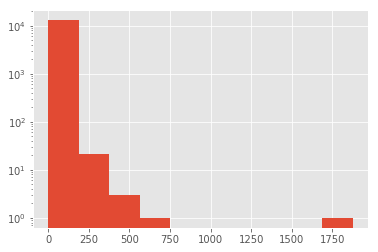

In [83]:
network_stats['indegree'].hist(log = True)

# things to store

In [84]:
remember('total_articles', articles.shape[0])

23131

In [85]:
# total number of citations in the sm dataset
remember('sm_citations', raw_edgelist.shape[0])

remember('sm_citing', len(raw_edgelist["from"].unique()))

# the number of articles in the original dataset that have any INCOMING citations
remember('sm_cited', len(raw_edgelist["to"].unique()))

35620

4807

3864

In [86]:
# total number of citations in the sm dataset
remember('all_citations', combo_raw_edgelist.shape[0])

remember('all_citing', len(combo_raw_edgelist["from"].unique()))

# the number of articles in the original dataset that have any INCOMING citations
remember('all_cited', len(combo_raw_edgelist["to"].unique()))

212773

42935

9710

In [87]:
remember('g_sm_clusters', g_sm_clu[["eid", "cluster"]])

eid  cluster
0     2-s2.0-71149088987        1
1     2-s2.0-70349816888        1
2     2-s2.0-79953711711        1
3     2-s2.0-79551630751        1
4     2-s2.0-80051469103        1
5     2-s2.0-84866718851        1
6     2-s2.0-84877685551        1
7     2-s2.0-84864442547        1
8     2-s2.0-84861420864        1
9     2-s2.0-84887483487        1
10    2-s2.0-80955144847        1
11    2-s2.0-84885038309        1
12    2-s2.0-84886099569        1
13    2-s2.0-84863379783        1
14    2-s2.0-84899093663        1
15    2-s2.0-84879109859        1
16    2-s2.0-83055168309        1
17    2-s2.0-84876304322        1
18    2-s2.0-84866168147        1
19    2-s2.0-84877817428        1
20    2-s2.0-84873481256        1
21    2-s2.0-84861794897        1
22    2-s2.0-84899508298        1
23    2-s2.0-84898082465        1
24    2-s2.0-84879021774        1
25    2-s2.0-80054988041        1
26    2-s2.0-84944394118        1
27    2-s2.0-84870572301        1
28    2-s2.0-84907167320        1
29    2-s2.0-84914675721        1
...                  ...      ...
6110  2-s2.0-84856086839       12
6111  2-s2.0-84859510122       12
6112  2-s2.0-84905121209       12
6113  2-s2.0-84883758613       12
6114  2-s2.0-84877953100       12
6115  2-s2.0-84904376766       12
6116  2-s2.0-84905837182       12
6117  2-s2.0-84900461218       12
6118  2-s2.0-83755228785       13
6119  2-s2.0-84886795975       13
6120  2-s2.0-84876132785       13
6121  2-s2.0-84903121334       13
6122  2-s2.0-84863720400       13
6123  2-s2.0-84873180938       13
6124  2-s2.0-84914112838       13
6125  2-s2.0-84878795748       13
6126  2-s2.0-84888011666       13
6127  2-s2.0-84942101218       13
6128  2-s2.0-80052752113       14
6129  2-s2.0-84874074707       14
6130  2-s2.0-84942582235       14
6131  2-s2.0-70849130360       14
6132  2-s2.0-84864152630       14
6133  2-s2.0-84868709161       15
6134  2-s2.0-84896350015       15
6135  2-s2.0-84944104933       15
6136  2-s2.0-84875539506       16
6137  2-s2.0-84902262954       16
6138  2-s2.0-84909954481       17
6139  2-s2.0-84921469678       18

[6140 rows x 2 columns]

In [88]:
sorted(r.keys())

['all_citations',
 'all_cited',
 'all_citing',
 'cluster_edgelist',
 'g_sm_clusters',
 'sm_citations',
 'sm_cited',
 'sm_citing',
 'total_articles']

In [89]:
#save the r function to rdata file
def save_to_r(r_dict, filename="output.RData"):
    for var_name, x in r.items():
        var_name = var_name.replace('_', '.')
        if type(x) == np.int64:
            x = np.asscalar(x)
        
        if type(x) == pd.DataFrame:
            rx = pandas2ri.py2ri(x)
        else:
            rx = x
        
        robjects.r.assign(var_name, x)

        # create a new variable called in R
    robjects.r("r <- sapply(ls(), function (x) {eval(parse(text=x))})")
    robjects.r('save("r", file="{}")'.format(filename))
    robjects.r("rm(list=ls())")
    
save_to_r(r, "../../paper/data/network_data.RData")